# Introduction

The purpose of this report is to show that **bias originating in the judgement of the technical elements portion of professional figure skating affects the component portion of the competition.** As a quick summary, the judged aspects of all professional figure skating performances are split into 2 categories:

1) **Technical elements** 

2) **Components**

Together the two categories make up the total segment score for the performance. Technical elements are calculated from a metric developed by the ISU Judging System meant to eliminate bias in this portion of the judging, while the component scores are designed to be more subjective. More information on each judged aspect will be discussed later in this report. 

The long program of ladies figure skating will be analyzed in order to standardize the scores, number of elements, as well as to study competitors that are relatively similar to one another. The first section of this report will explore the differences in the components and elements, provide visualizations on their importance to the overall segment score, and further discuss the hypothesis. The second section will test this hypothesis through machine learning models. The third section identifies possible forms of bias and summarizes the results. 

# 1) Exploration of the Judged Aspects of Professional Figure Skating

There are four types of competition in professional figure skating:
- **Mens**
- **Ladies**
- **Pairs**
- **Ice Dancing**

The scoring for each type of competition differs according to the new [ISU Judging System](https://en.wikipedia.org/wiki/ISU_Judging_System). Each type of competition has a long program, or free skate, and a short program.

The [data used in this report](https://drive.google.com/drive/folders/16Ad949NhaWhHYYfUKFPPiAsR68piFVJH) contains information on figure skating competitions, judges and skaters from 2016-2017. The data shows both element and component scores, aspects of each judged category, and information on the judges themselves. The performances.csv and judged-aspects.csv datasets are used in this report, showing 23932 datapoints from 17 competitions.  

The data for the performances and judged aspects were combined into the performances_judges.csv dataset using SQL. This provides a dataframe that shows the elements and components of each skater during each competition they participated in. The SQL code is as follows:

**select** 
   
    *
   
**from**

    performances
    
**left join**
    
    judged_aspects
    
**on**
    
    performances.performance_id=judged_aspects.performance_id 

## Summary of the ladies' long program

The ladies' long program has more technical elements and components to analyze, so this section will be the focus of this report. Here is a quick summary of the typical performance in the ladies long program:

**Maximum of seven jump elements:**
- One must be an axel type jump
- Maximum of three jump combinations/sequences; one jump combination may contain three jumps
- Double jumps cannot be included more than twice
- Of all the triple and quadruple jumps only two can be executed twice; of the two, only one can be a quadruple jump

**Maximum of three spins:**
- One combination spin; minimum of 10 revolutions
- One flying spin or spin with a flying entrance; minimum of six revolutions
- One spin with only one position; minimum of six revolutions
- A change of foot optional in all spins

**Maximum of one step sequence**

**Maximum of one choreographic sequence**



Skaters can choose the order of the above elements, but all elements must be in one performance. Jumps from the second half of a performance also recieve a 10% bonus to the overall element score. 

## Data inspection/cleaning

In [1]:
# load and inspect data
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
path=r"/Users/kyleknoebel/Desktop/ThinkfulNotebooks/Unit 3 Capstone/performances_judged.csv"
pj=pd.read_csv(path)
# replace all null values with 0
pj=pj.fillna(0)
pj.describe()

,rank,starting_number,total_segment_score,total_element_score,total_component_score,total_deductions,aspect_num,base_value,factor,goe,ref,scores_of_panel
count,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.0,23932.000000
mean,7.883169,7.929550,99.361830,50.394217,49.395199,0.427586,3.431765,3.143990,0.438743,0.278006,0.0,6.147335
std,6.525922,6.548071,37.110716,18.879934,18.907632,0.751289,3.641213,3.167566,0.639486,0.834628,0.0,2.536225
min,1.000000,1.000000,24.550000,8.750000,15.800000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.0,0.000000
25%,3.000000,3.000000,68.250000,35.570000,32.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.070000
50%,6.000000,6.000000,93.480000,46.970000,46.420000,0.000000,2.000000,3.000000,0.000000,0.000000,0.0,6.300000
75%,10.000000,10.000000,126.510000,62.600000,64.410000,1.000000,6.000000,5.000000,0.800000,0.710000,0.0,7.860000
max,37.000000,37.000000,223.200000,126.120000,97.080000,9.000000,14.000000,17.900000,2.000000,3.300000,0.0,20.330000


In [2]:
# show the listing of columns with proper indexing
for index, value in enumerate(pj, 1):
    print("{}. {}".format((index-1), value))

0. performance_id
1. competition
2. competition1
3. name
4. nation
5. rank
6. starting_number
7. total_segment_score
8. total_element_score
9. total_component_score
10. total_deductions
11. aspect_id
12. performance_id-2
13. section
14. aspect_num
15. aspect_desc
16. info_flag
17. credit_flag
18. base_value
19. factor
20. goe
21. ref
22. scores_of_panel


### Clean the data and create data frames for elements and components

First, the dataset will be cleaned for better formatting/slicing.

In [3]:
# lower the capilization of the program and competition1 columns to standardize formatting
pj.iloc[:, 2] = pj.iloc[:, 2].str.lower()
pj.iloc[:, 1] = pj.iloc[:, 1].str.lower()
# clean the text for interpretations
pj.iloc[:, 15]=pj.iloc[:, 15].str.replace('Interpretation of the Music / Timing', 
                                                        'Interpretation of the Music')
pj.iloc[:, 15]=pj.iloc[:, 15].str.replace('Interpretation of the Music/Timing', 
                                                        'Interpretation of the Music')
# remove ice dancing from the dataset
pj=pj[~pj['competition1'].str.contains('ice dance')]
#remove short program from the dataset
pj=pj[~pj['competition1'].str.contains('short')]

Then a column for the type of element will be added called 'elem_type.' Types of elements will be discussed later in the report, and a list of abbreviations can be found in Appendix A.  

In [4]:
# add element type for each technical element
pj.loc[pj['aspect_desc'].str.contains('Sp'), 'elem_type']='spin'
pj.loc[pj['aspect_desc'].str.contains('Sq'), 'elem_type']='step'
pj.loc[pj['aspect_desc'].str.contains('Th'), 'elem_type']='throw jump'
pj.loc[pj['aspect_desc'].str.contains('Tw'), 'elem_type']='twist lift'
pj.loc[pj['aspect_desc'].str.contains('Li'), 'elem_type']='lift'
pj.loc[pj['aspect_desc'].str.contains('Ds' or 'Pi'), 'elem_type']='death spirals'
pj.loc[pj['aspect_desc'].str.contains('PsP' or 'PCoSp'), 'elem_type']='pair spins'
# the remaining rows with NaN in the elem_type column are either jumps or components
## since all jumps have a number in the aspect_desc and components do not, the jumps will be selected for using:
pj.loc[pj['aspect_desc'].str.contains('(\d+)') & (pj['elem_type'].isnull()), 'elem_type']='jump'

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


Next, create separate dataframes for components and elements, and also create a separate dataste for the pairs competition since the elements in pairs skating differ from the singles categories. 

In [5]:
# create separate dataframe for ladies competition
# find the rows that contain 'ladies' in the name of each program category in the data frame 
ladies=pj[pj.iloc[:, 2].str.contains('ladies' , regex=False, case=False, na=False)]

# create separate dataframes for components and elements
elems=ladies[ladies['section']=='elements']
compos=ladies[ladies['section']=='components']

# create a data frame for the components of the ladies
ladies_compo=ladies[ladies.iloc[:, 13].str.contains('components', regex=False, case=False, na=False)]
# create a data frame for the elements of the ladies
ladies_elem=ladies[ladies.iloc[:, 13].str.contains('elements', regex=False, case=False, na=False)]

The aspect_desc for the components will be converted to a categorical variable for modelling. 

In [6]:
# recategorize the object columns as category
compos_model=ladies_compo.copy()
compos_model = pd.concat([
        compos.select_dtypes([], ['object']),
       compos.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(compos.columns, axis=1)
# create categorical values
objs=compos_model[['aspect_desc']]
objs= objs.apply(lambda x: x.cat.codes)
objs=objs.rename(columns={"aspect_desc": "aspect_cat"})
# drop string values and add categorical values
compos_model=pd.concat([compos_model, objs], 1)

## Exploring elements

The technical elements of ladies competitions are organized into the following categories:
- jumps
- spins
- steps

More information for the codes for the different categories can be found in Appendix A at the end of the document. The element scores are calculated by awarding a grade of execution (GOE) factor for each element, which is then translated into a value using a scale of value (SOV), shown in Appendix B. The GOE values are then averaged using a [trimmed mean](https://en.wikipedia.org/wiki/Truncated_mean) process, and finally the averaged value is added to the base value for the element. 

Since the scoring for the element category is somewhat complicated, the following visualizations will aim to show how the element types and scores are distributed in the data.

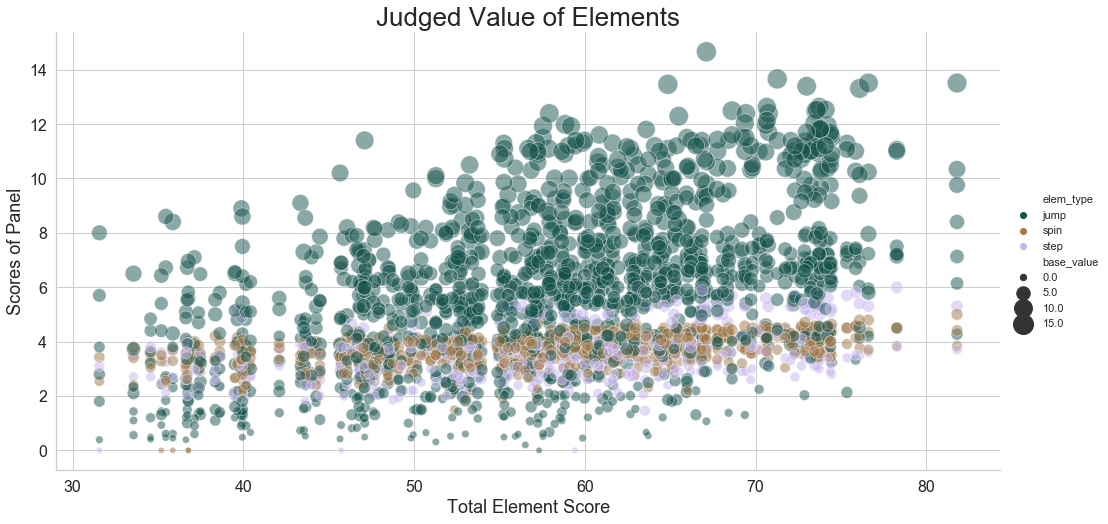

In [7]:
# create a relplot showing the type of elements in the dataset
sns.set(style='whitegrid')
sns.relplot(x="total_element_score", y="scores_of_panel", hue="elem_type", size="base_value",
            sizes=(40, 400), alpha=.5, palette="cubehelix", height=7, aspect=2,
            data=ladies_elem)
plt.title('Judged Value of Elements', fontsize=26)
plt.ylabel('Scores of Panel', fontsize=18)
plt.xlabel('Total Element Score', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

In [8]:
ladies_elem['elem_type'].value_counts()

jump    1600
spin     686
step     447
Name: elem_type, dtype: int64

Jumps tend to make up a larger majority of the total element score, and jumps are the most attempted element in the data.  

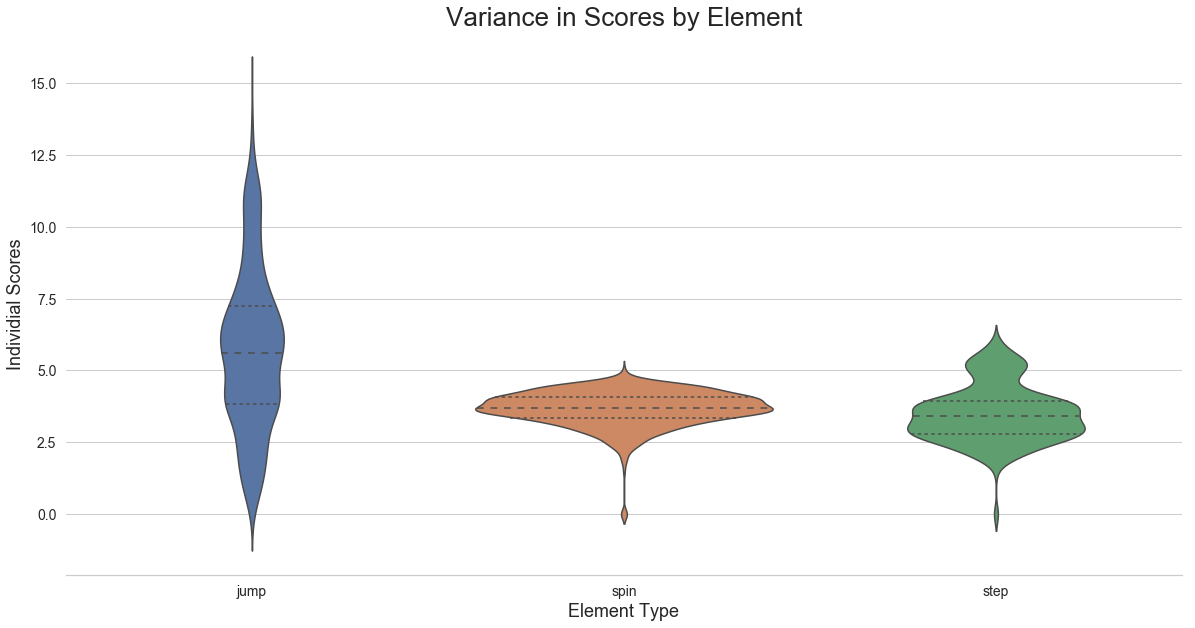

In [9]:
# plot the variance in scores by type of comoponent
plt.figure(figsize=(20, 10))
sns.violinplot(x="elem_type", y="scores_of_panel",
               split=True, inner="quart",
               data=ladies_elem)
plt.xlabel('Element Type', fontsize=18)
plt.ylabel('Individial Scores', fontsize=18)
plt.title('Variance in Scores by Element', fontsize=26)
plt.tick_params(axis='both', which='both', labelsize=14)
sns.despine(left=True)

Jumps are the technical element most attempted, that recieve the highest score, and also have the most varaince among the scores.

## Exploring components

Program Component Scores (PCS) fall into five categories:
- Skating Skills
- Transitions
- Performance
- Composition
- Interpretation of the Music/Timing

Component scores are based on a 1-10 scale, are not averaged nor dependent on a GOE, but components can be marked for deductions and are based on a factor depending on type category of competition (mens, ladies, pairs). The components are [largely considered the more artistic](https://www.vox.com/culture/2018/2/14/17004314/figure-skating-scoring-winter-olympics-2018), or subjective, of the two judged aspects, and therefore considered the most open to interpretation. How do the component scores compare to the scores of the panel? 

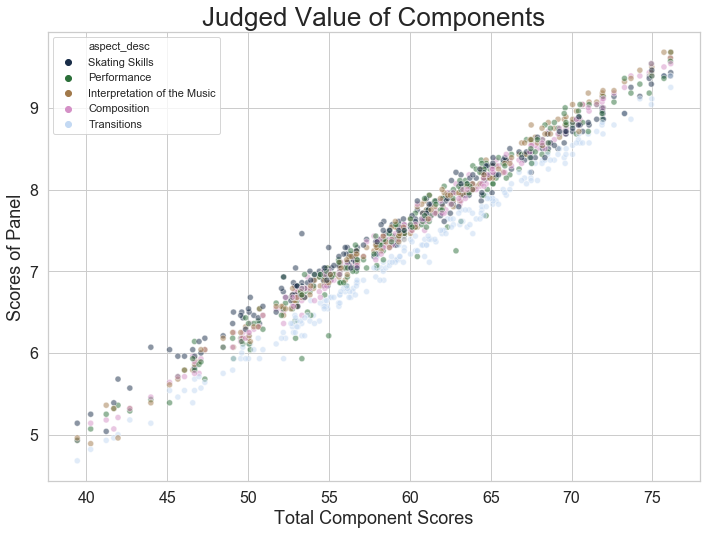

In [10]:
# create a scatter of total component scores vs. the scores of the panel by program type
sns.set(style='whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="total_component_score", y="scores_of_panel", hue="aspect_desc", alpha=.5, palette="cubehelix", 
                data=ladies_compo)
plt.title('Judged Value of Components', fontsize=26)
plt.ylabel('Scores of Panel', fontsize=18)
plt.xlabel('Total Component Scores', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

This chart shows that component scores are much less varied than the technical elements. This is likely due to the scale components are judged on, which also means they could make a good indicator population when exploring the relationship between technical elements and components.

In addition, the chart shows that transitions are nearly always the component with the lowest score amongst all ladies performances in the data. 

## Relationship between elements and components

The analysis above shows that despite components being considered the most subjective of the two judged aspects, elements tend to have the largest variance among individual scores, and have a larger range of total scores (as shown by the the x-axes of both 'Judged Value' plots above). Since components are judged on a scale as oppose to a GOE factor, the component scores are naturally more uniform than their counterparts. How does each cateogry compare to the other? 

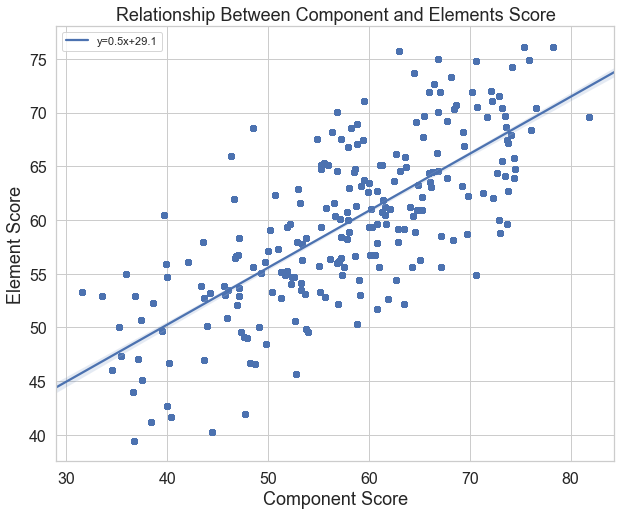

In [11]:
sns.set(style='whitegrid')
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(ladies['total_element_score'],
                                                               ladies['total_component_score'])
# create plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax=sns.regplot(x='total_element_score', y='total_component_score', data=ladies,
            line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('Relationship Between Component and Elements Score', fontsize=18)
plt.ylabel('Element Score', fontsize=18)
plt.xlabel('Component Score', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
# plot legend
ax.legend()
plt.show()

There is a clear linear relationship between the component and element scores. This relationship further supports the hypothesis that technical elements affect the score of components in ladies professional figure skating. 

While this chart by no means proves the hypothesis one way or another, it does show that a trend exists which deserves further analysis. 

# 2) Predicting the relationship between elements and components

A gradient boosting machine will be used to test the hypothesis that component scores can be predicted from the attributes of an element score. The H2O Flow gradient boosting estimator will be used as it gives a better opportunity to explore the statisical significance of the results.

## Data engineering

### Create data table

In order to properly train the model, the data will be organized to show the selected data for each performance. Since the hypothesis posits that the attributes of an element score affect the component score, the base values, GOE's, and deductions of the element portion will be selected. 

Since the GOE shown in the data is the averaged value, a new GOE will be calculated by dividing the GOE by the base value to show the true GOE value awarded when the element is performed. Total deductions will also be removed now and added to the final model dataframe as the deduction in each line is the total number of deductions for the performance.  

In [12]:
# create a dataframe with only variables of interest and show format
df_model = ladies_elem.drop(['competition', 'competition1', 'name', 'nation', 'rank', 'starting_number', 
                         'total_segment_score', 'total_element_score', 'total_component_score', 'aspect_id',
                        'performance_id-2', 'section', 'factor', 'aspect_num', 'aspect_desc', 'info_flag', 
                             'credit_flag', 'ref', 'scores_of_panel', 'elem_type'], 1)
# create actual GOE value and remove old value
df_model['goe_actual']=df_model['goe']/df_model['base_value']
df_model.head()

,performance_id,total_deductions,base_value,goe,goe_actual
10,e37083608d,0.0,3.63,0.14,0.038567
21,1b967c18c5,0.0,3.50,0.07,0.020000
26,2adfc0ee61,0.0,3.63,0.71,0.195592
32,64a3a7349a,0.0,2.70,1.00,0.370370
39,3c12ecb0ee,0.0,7.26,0.50,0.068871


In order to organize the data for each performance, a rank column will be added to the elements for each performance id. This rank will then be used to sort the elements from highest to lowest base value, while keeping the element attributes (base value, goe, element category) in the same corresponding pattern. This means the highest base value score will be first, while it's corresponding GOE will be first among that category. This will add logic to the table that will ensure the GBM model is accurate. 

In addition, the total deductions shown in each row of the data is the total number of deductions in the performance. As such, the total deductions will be removed from the data and appended at the end of the engineering process.  

In [13]:
# add a rank column to rank the base values by performance id
df_model["rank"] = df_model.groupby("performance_id")["base_value"].rank("dense", ascending=False)
df_model=df_model.reset_index()
# sort the values by this ranking
df_model=df_model.sort_values('rank')
df_model.head()

,index,performance_id,total_deductions,base_value,goe,goe_actual,rank
2416,21048,059039bcf6,0.0,11.22,0.6,0.053476,1.0
1063,9525,c351343d7d,0.0,8.30,-0.4,-0.048193,1.0
747,6647,7d9640cf7e,1.0,9.60,1.3,0.135417,1.0
296,2667,8712edfbc0,0.0,8.20,0.8,0.097561,1.0
294,2658,265a603120,0.0,11.33,-0.5,-0.044131,1.0


In [14]:
# create separate data frame for deductions
df_deduc=df_model.copy()
df_deduc=df_deduc.drop(['base_value', 'goe', 'goe_actual', 'rank'], 1)
# drop duplicate performances
df_deduc['performance_id']=df_deduc['performance_id'].drop_duplicates()
df_deduc=df_deduc.dropna()
df_deduc.head()

,index,performance_id,total_deductions
2416,21048,059039bcf6,0.0
1063,9525,c351343d7d,0.0
747,6647,7d9640cf7e,1.0
296,2667,8712edfbc0,0.0
294,2658,265a603120,0.0


In [15]:
# create a pivot table showing the base value, goe, and deductions for each performance
df_model=pd.pivot_table(df_model, index=['performance_id'], columns=df_model.groupby(['performance_id']).cumcount().add(1), 
                  values=['base_value','goe_actual', 'rank'], aggfunc='sum')
# relabel columns with proper titles
df_model.columns=df_model.columns.map('{0[0]}{0[1]}'.format) 
# reset index for modeling
df_model=df_model.reset_index()
# drop the ranks columns, they are not needed for model
df_model=df_model.drop(['rank1', 'rank2', 'rank3', 'rank4', 'rank5', 'rank6', 'rank7', 'rank8', 'rank9', 'rank10',
                       'rank11', 'rank12'], 1)
# add the deduction column 
df_model=df_model.merge(df_deduc, how='left', on=['performance_id'])
df_model.head()

,performance_id,base_value1,base_value2,base_value3,base_value4,base_value5,base_value6,base_value7,base_value8,base_value9,...,goe_actual5,goe_actual6,goe_actual7,goe_actual8,goe_actual9,goe_actual10,goe_actual11,goe_actual12,index,total_deductions
0,010e399739,9.46,8.60,6.00,5.61,4.84,3.70,3.63,3.5,3.30,...,-0.330579,-0.486486,0.195592,0.225714,0.193939,0.156250,0.190000,0.650000,14650,0.0
1,018b293978,10.30,8.36,5.61,5.30,4.84,3.90,3.50,3.3,3.00,...,0.144628,0.282051,0.182857,0.151515,0.190000,0.166667,0.400000,-0.318182,18582,0.0
2,01b0b01f6f,8.25,6.60,6.00,5.54,5.10,3.63,3.30,3.2,3.00,...,0.000000,0.000000,0.151515,0.134375,0.070000,0.208333,0.100000,-0.181818,340,0.0
3,01e5ba3b8e,8.60,8.20,6.00,5.83,5.61,5.06,4.62,3.2,3.00,...,0.089127,0.057312,-0.454545,0.246875,0.010000,0.165385,0.029167,0.450000,18815,2.0
4,0375e990b4,11.99,9.60,6.00,5.61,3.63,3.63,3.50,3.0,2.77,...,0.019284,0.079890,0.162857,0.166667,-0.758123,0.022222,0.384615,0.500000,16178,1.0


### Create target table

The target table will be the total component score of each performance. The process below will show the scores of each component per performance, but this data is only shown in case it is necessary for future analysis. The individual scores will not be used in the model.

In [16]:
# only keep variables of interest for modeling
df_target=compos_model.drop(['competition', 'competition1', 'name', 'nation', 'rank', 'starting_number', 
                             'total_segment_score', 'total_element_score', 'total_deductions', 'aspect_id', 
                             'performance_id-2', 'section', 'aspect_num', 'info_flag', 
                             'credit_flag', 'base_value', 'factor', 'goe', 'ref', 'elem_type', 'aspect_desc',
                            'total_component_score'], 
                            1)
# create pivot table of values
df_target=pd.pivot_table(df_target, index=["performance_id"], columns=['aspect_cat'],
                         values=(['scores_of_panel']), aggfunc='sum')
# add total column to target table
df_target['total_score']=df_target.sum(axis=1)
# multiply by 2 to account for the factor 
df_target['total_score']=df_target['total_score']*2
# reset index
df_target=df_target.reindex()
df_target.head()

scores_of_panel                         total_score
aspect_cat                   0     1     2     3     4            
performance_id                                                    
010e399739                8.21  8.14  8.18  8.29  7.89       81.42
018b293978                7.82  7.82  7.82  8.11  7.54       78.22
01b0b01f6f                6.07  6.18  6.07  6.21  5.75       60.56
01e5ba3b8e                7.68  7.75  7.68  7.82  7.39       76.64
0375e990b4                8.36  8.43  8.25  8.46  8.21       83.42

Then the total score is added to the end of the model dataframe to create one model dataframe. 

In [17]:
# add the total score column from the target table to the model table
df_model=df_model.merge(df_target['total_score'], how='left', on=['performance_id'])
df_model.head()

,performance_id,base_value1,base_value2,base_value3,base_value4,base_value5,base_value6,base_value7,base_value8,base_value9,...,goe_actual6,goe_actual7,goe_actual8,goe_actual9,goe_actual10,goe_actual11,goe_actual12,index,total_deductions,total_score
0,010e399739,9.46,8.60,6.00,5.61,4.84,3.70,3.63,3.5,3.30,...,-0.486486,0.195592,0.225714,0.193939,0.156250,0.190000,0.650000,14650,0.0,81.42
1,018b293978,10.30,8.36,5.61,5.30,4.84,3.90,3.50,3.3,3.00,...,0.282051,0.182857,0.151515,0.190000,0.166667,0.400000,-0.318182,18582,0.0,78.22
2,01b0b01f6f,8.25,6.60,6.00,5.54,5.10,3.63,3.30,3.2,3.00,...,0.000000,0.151515,0.134375,0.070000,0.208333,0.100000,-0.181818,340,0.0,60.56
3,01e5ba3b8e,8.60,8.20,6.00,5.83,5.61,5.06,4.62,3.2,3.00,...,0.057312,-0.454545,0.246875,0.010000,0.165385,0.029167,0.450000,18815,2.0,76.64
4,0375e990b4,11.99,9.60,6.00,5.61,3.63,3.63,3.50,3.0,2.77,...,0.079890,0.162857,0.166667,-0.758123,0.022222,0.384615,0.500000,16178,1.0,83.42


The only remaining questions is what distribution to use in the model? 

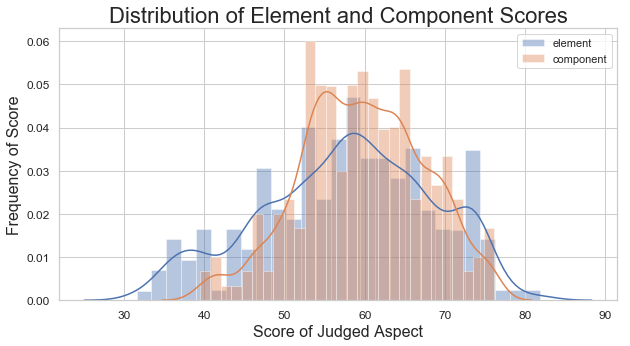

In [18]:
# show the distribution of component and element scores
plt.figure(figsize=(10, 5))
ax=sns.distplot(ladies['total_element_score'], label='element')
ax=sns.distplot(ladies['total_component_score'], label='component')
plt.title('Distribution of Element and Component Scores', fontsize=22)
plt.xlabel('Score of Judged Aspect', fontsize=16)
plt.ylabel('Frequency of Score', fontsize=16)
ax.legend()
plt.tick_params(axis='both', which='major', labelsize=12)

The distributions of the element and component scores are normal. The distribution of the GBM model should match the dsitribution of the response variable, so a gaussian distribution will be used. 

### Run model

In [19]:
import h2o
h2o.init()
from h2o.estimators.gbm import H2OGradientBoostingEstimator
# convert pandas dataframe to h2o dataframe
df_run_model=h2o.H2OFrame(df_model)
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
train,test,valid = df_run_model.split_frame(ratios=[0.7, 0.15])
gbm = H2OGradientBoostingEstimator(distribution = "gaussian", ntrees=100, learn_rate=0.1, sample_rate=0.75, 
                                   max_depth=4, nfolds=5, keep_cross_validation_predictions = True, 
                                   stopping_metric='deviance', seed=1234)
gbm.train(y='total_score', x=['base_value1', 'base_value2', 'base_value3', 'base_value4', 'base_value5', 
                             'base_value6', 'base_value7', 'base_value8', 'base_value9', 'base_value10',
                             'base_value11', 'base_value12', 'goe_actual1', 'goe_actual2', 'goe_actual3', 
                             'goe_actual4', 'goe_actual5', 'goe_actual6', 'goe_actual7', 'goe_actual8', 
                             'goe_actual9', 'goe_actual10', 'goe_actual11', 'goe_actual12', 'total_deductions'], 
          training_frame=train, validation_frame=train)
# show cross validation scores
cv_summary = gbm.cross_validation_metrics_summary().as_data_frame()
print(cv_summary)
# run validation testing
print(gbm.model_performance(valid=True))

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/kyleknoebel/anaconda3/h2o_jar/h2o.jar
  Ice root: /var/folders/9j/nmg9nt1n0hv2wyylxv2f4_xh0000gn/T/tmpioyk35wf
  JVM stdout: /var/folders/9j/nmg9nt1n0hv2wyylxv2f4_xh0000gn/T/tmpioyk35wf/h2o_kyleknoebel_started_from_python.out
  JVM stderr: /var/folders/9j/nmg9nt1n0hv2wyylxv2f4_xh0000gn/T/tmpioyk35wf/h2o_kyleknoebel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,11 months and 2 days !!!
H2O cluster name:,H2O_from_python_kyleknoebel_8ee316
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
                                 mean            sd   cv_1_valid  cv_2_valid  \
0                     mae   3.5870585    0.24666834    3.2672966   4.1972613   
1  mean_residual_deviance   21.115566     2.8642073     18.88758   27.626787   
2                     mse   21.115566     2.8642073     18.88758   27.626787   
3                      r2   0.7798661   0.032428175    0.8451646  0.70439506   
4       residual_deviance   21.115566     2.8642073     18.88758   27.626787   
5                    rmse   4.5747895    0.30566937    4.3459845   5.2561193   
6                   rmsle  0.06422262  0.0032810639  0.064116165  0.07092826   

    cv_3_valid cv_4_valid  cv_5_valid  
0    3.4181762  3.7475803   3.3049786  
1    18.315437   23.96124   16.786789  
2    18.315437   23.96124   16.786789  
3   0.79315186  0.7919977  0.76462126

<Figure size 2500x1000 with 0 Axes>

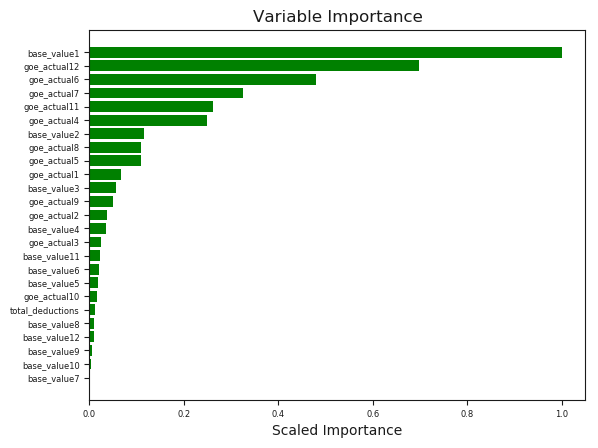

In [20]:
plt.rcdefaults()
plt.figure(figsize=(25, 10))
fig, ax = plt.subplots()
variables = gbm._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = gbm._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=6)
plt.show()

The fact that the goe_actual12 has the most importance among the GOE features shows that the goe of the lowest scoring element has the most effect on the component score. Interestingly the base value of the highest scoring element has the most weight on the model. This could show that the judges are swayed by the highest and lowest scoring elements in the performance. 

There is some imbalance in the data, likely arising from multicollinearity amongst the features. What happens when the model is run on just GOE and base value features?

### GOE model

In [22]:
gbm_goe = H2OGradientBoostingEstimator(distribution = "gaussian", ntrees=100, learn_rate=0.1, sample_rate=0.75, 
                                   max_depth=4, nfolds=5, keep_cross_validation_predictions = True, 
                                   stopping_metric='deviance', seed=1234)
gbm_goe.train(y='total_score', x=['goe_actual1', 'goe_actual2', 'goe_actual3', 
                             'goe_actual4', 'goe_actual5', 'goe_actual6', 'goe_actual7', 'goe_actual8', 
                             'goe_actual9', 'goe_actual10', 'goe_actual11', 'goe_actual12'], 
          training_frame=train, validation_frame=train)
# show cross validation scores
cv_summary_goe = gbm_goe.cross_validation_metrics_summary().as_data_frame()
print(cv_summary_goe)
# run validation testing
print(gbm_goe.model_performance(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
                                 mean           sd   cv_1_valid  cv_2_valid  \
0                     mae   3.9435306   0.29755127    3.2450097   4.5707865   
1  mean_residual_deviance   26.196426    4.5400333     17.16726    36.86748   
2                     mse   26.196426    4.5400333     17.16726    36.86748   
3                      r2  0.72093034  0.060327284   0.85926735   0.6055202   
4       residual_deviance   26.196426    4.5400333     17.16726    36.86748   
5                    rmse   5.0798383   0.44253308     4.143339     6.07186   
6                   rmsle  0.07151337  0.006012601  0.058337018  0.08378718   

   cv_3_valid  cv_4_valid   cv_5_valid  
0   3.9783285   3.9942448    3.9292839  
1   25.738323   27.819397    23.389673  
2   25.738323   27.819397    23.389673  
3   0.7093204   0.7585058    0.6720378  
4   25.738323   27.819397    23.389673  
5    5.073295     5.27441     4.836287  

<Figure size 2500x1000 with 0 Axes>

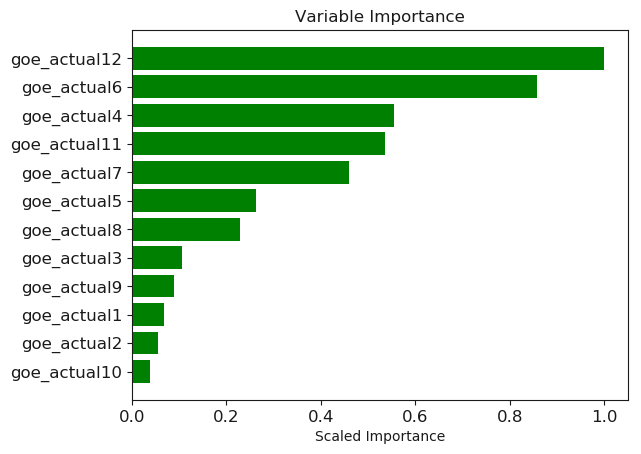

In [23]:
plt.rcdefaults()
plt.figure(figsize=(25, 10))
fig, ax = plt.subplots()
variables = gbm_goe._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = gbm_goe._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### Base value model

In [24]:
gbm_bv = H2OGradientBoostingEstimator(distribution = "gaussian", ntrees=100, learn_rate=0.1, sample_rate=0.75, 
                                   max_depth=4, nfolds=5, keep_cross_validation_predictions = True, 
                                   stopping_metric='deviance', seed=1234)
gbm_bv.train(y='total_score', x=['base_value1', 'base_value2', 'base_value3', 'base_value4', 'base_value5', 
                             'base_value6', 'base_value7', 'base_value8', 'base_value9', 'base_value10',
                             'base_value11', 'base_value12'], 
          training_frame=train, validation_frame=train)
# show cross validation scores
cv_summary_bv = gbm_bv.cross_validation_metrics_summary().as_data_frame()
print(cv_summary_bv)
# run validation testing
print(gbm_bv.model_performance(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
                                 mean          sd  cv_1_valid  cv_2_valid  \
0                     mae    5.312034  0.60576713    4.869537     5.24109   
1  mean_residual_deviance   48.042717   10.377319   44.031254    45.38475   
2                     mse   48.042717   10.377319   44.031254    45.38475   
3                      r2  0.51292783  0.06952737   0.6390434  0.51438594   
4       residual_deviance   48.042717   10.377319   44.031254    45.38475   
5                    rmse    6.855235   0.7240407    6.635605   6.7368207   
6                   rmsle  0.09310809  0.00927429  0.09528442  0.08832154   

   cv_3_valid  cv_4_valid   cv_5_valid  
0   5.4067373   6.8198757    4.2229304  
1    46.22816    74.80636    29.763058  
2    46.22816    74.80636    29.763058  
3  0.47791535   0.3506222   0.58267236  
4    46.22816    74.80636    29.763058  
5   6.7991295    8.649067     5.455553  
6  0.09372069  

<Figure size 2500x1000 with 0 Axes>

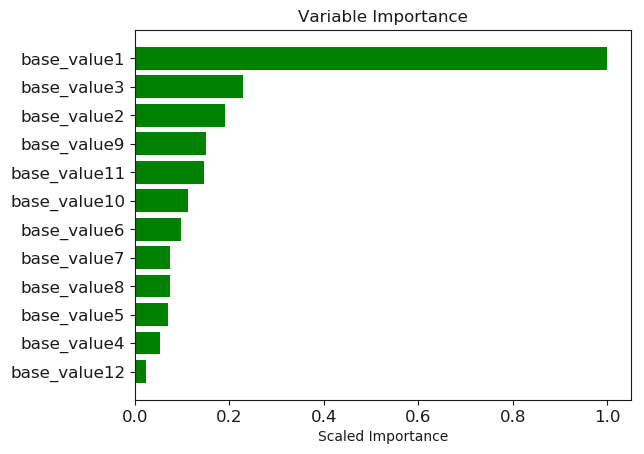

In [25]:
plt.rcdefaults()
plt.figure(figsize=(25, 10))
fig, ax = plt.subplots()
variables = gbm_bv._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = gbm_bv._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The cross validation scores and validation testing improve when the model is run on just GOE scores, and the opposite is true for base value scores. This shows that the GOE is the most important feature for predicting component scores.  

### Chronological model

In order to test whether the model is improved by organizing the data by value rather than chrnologically, the same model will be run on chronologucal data. 

In [26]:
# create a dataframe 
df_chrono = ladies_elem.drop(['competition', 'competition1', 'name', 'nation', 'rank', 'starting_number', 
                         'total_segment_score', 'total_element_score', 'total_component_score', 'aspect_id',
                        'performance_id-2', 'section', 'factor', 'aspect_num', 'aspect_desc', 'info_flag', 
                             'credit_flag', 'ref', 'scores_of_panel'], 1)
# create actual GOE value and remove old value
df_chrono['goe_actual']=df_chrono['goe']/df_chrono['base_value']
# create separate data frame for deductions
df_deduc=ladies_elem.copy()
df_deduc=df_deduc.drop(['base_value', 'goe', 'elem_type'], 1)
# drop duplicate performances
df_deduc['performance_id']=df_deduc['performance_id'].drop_duplicates()
df_deduc=df_deduc.dropna()
# create a pivot table showing the base value, goe, and deductions for each performance
df_chrono=pd.pivot_table(df_chrono, index=['performance_id'], columns=df_chrono.groupby(['performance_id']).cumcount().add(1), 
                  values=['base_value','goe_actual'], aggfunc='sum')
# relabel columns with proper titles
df_chrono.columns=df_chrono.columns.map('{0[0]}{0[1]}'.format) 
# reset index for modeling
df_chrono=df_chrono.reset_index()
# add the deduction column 
df_chrono=df_chrono.merge(df_deduc, how='left', on=['performance_id'])
# add the mean score column from the target table to the model table
# add the mean score column from the target table to the model table
df_chrono=df_chrono.merge(df_target['total_score'], how='left', on=['performance_id'])
df_chrono.head()

,performance_id,base_value1,base_value2,base_value3,base_value4,base_value5,base_value6,base_value7,base_value8,base_value9,...,performance_id-2,section,aspect_num,aspect_desc,info_flag,credit_flag,factor,ref,scores_of_panel,total_score
0,010e399739,4.84,3.20,3.63,3.7,2.00,3.50,5.61,8.60,9.46,...,010e399739,elements,10.0,3S,0,x,0.0,0.0,3.24,81.42
1,018b293978,3.50,4.84,3.30,3.0,5.61,8.36,3.00,5.30,3.90,...,018b293978,elements,12.0,FCCoSp4,0,0,0.0,0.0,4.14,78.22
2,01b0b01f6f,8.25,3.00,6.00,2.4,3.20,2.00,5.54,5.10,0.55,...,01b0b01f6f,elements,7.0,3S+2T+2Lo,0,x,0.0,0.0,8.25,60.56
3,01e5ba3b8e,5.83,2.40,2.00,8.2,5.61,3.00,3.20,4.62,2.60,...,01e5ba3b8e,elements,7.0,3F,0,x,0.0,0.0,3.73,76.64
4,0375e990b4,5.61,6.00,2.77,3.0,3.50,2.70,3.63,11.99,3.63,...,0375e990b4,elements,7.0,3Lo,0,x,0.0,0.0,4.71,83.42


In [27]:
# convert pandas dataframe to h2o dataframe
df_run_chrono=h2o.H2OFrame(df_chrono)
# Split the data into Train/Test/Validation with Train having 70% and test and validation 15% each
train,test,valid = df_run_chrono.split_frame(ratios=[0.7, 0.15])
gbm_chrono = H2OGradientBoostingEstimator(distribution = "gaussian", ntrees=100, learn_rate=0.1, sample_rate=0.75, 
                                   max_depth=4, nfolds=5, keep_cross_validation_predictions = True, 
                                   stopping_metric='deviance', seed=1234)
gbm_chrono.train(y='total_score', x=['base_value1', 'base_value2', 'base_value3', 'base_value4', 'base_value5', 
                             'base_value6', 'base_value7', 'base_value8', 'base_value9', 'base_value10',
                             'base_value11', 'base_value12', 'goe_actual1', 'goe_actual2', 'goe_actual3', 
                             'goe_actual4', 'goe_actual5', 'goe_actual6', 'goe_actual7', 'goe_actual8', 
                             'goe_actual9', 'goe_actual10', 'goe_actual11', 'goe_actual12', 'total_deductions'], 
          training_frame=train, validation_frame=train)
# show cross validation scores
cv_summary_chrono = gbm_chrono.cross_validation_metrics_summary().as_data_frame()
print(cv_summary_chrono)
# run validation testing
print(gbm_chrono.model_performance(valid=True))

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm Model Build progress: |███████████████████████████████████████████████| 100%
                                 mean           sd  cv_1_valid  cv_2_valid  \
0                     mae   4.4375978   0.58667064   5.6256943   4.5909743   
1  mean_residual_deviance    32.68633     9.974677   57.938244   35.123596   
2                     mse    32.68633     9.974677   57.938244   35.123596   
3                      r2  0.64457816  0.094924934  0.43322265  0.66512376   
4       residual_deviance    32.68633     9.974677   57.938244   35.123596   
5                    rmse   5.5938005   0.83538145   7.6117177   5.9265165   
6                   rmsle   0.0767415  0.013087956   0.1108671  0.07811327   

    cv_3_valid  cv_4_valid   cv_5_valid  
0    3.5658426   3.4489312    4.9565463  
1    19.440119    19.48235    31.447336  
2    19.440119    19.48235    31.447336  
3   0.75595665  0.80564934   0.56293833  
4  

<Figure size 2500x1000 with 0 Axes>

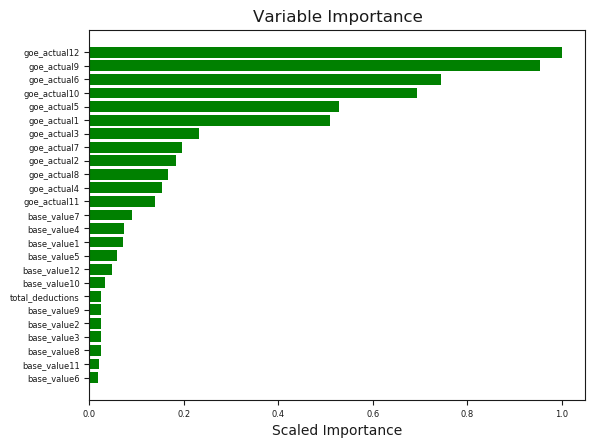

In [28]:
plt.rcdefaults()
plt.figure(figsize=(25, 10))
fig, ax = plt.subplots()
variables = gbm_chrono._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = gbm_chrono._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=6)
plt.show()

The model accuracy shows that the value of the elements is more important than their order in the performance when predicting component scores. 

### Test on other data

The original data also include performances from the 2016 Olympics, data which was not included in this analysis. How does the model perform when predicting the component scores of these performances?  

In [30]:
# import olympic performance data
path=r"/Users/kyleknoebel/Desktop/ThinkfulNotebooks/Unit 3 Capstone/performances_2018O.csv"
test_perf=pd.read_csv(path)
path2=r"/Users/kyleknoebel/Desktop/ThinkfulNotebooks/Unit 3 Capstone/judged-aspects_2018O.csv"
test_asp=pd.read_csv(path2)
test_perf['total_deductions']=test_perf['total_deductions'].astype(str)
test_perf['total_deductions']=test_perf['total_deductions'].str.replace('-', ' ')
test_perf['total_deductions']=test_perf['total_deductions'].astype(float)
# merge the dataframes
df_test=test_perf.merge(test_asp, how='left', on=['performance_id'])
# fill null values
df_test=df_test.fillna(0)
df_test.head()

,performance_id,competition,program,name,nation,rank,starting_number,total_segment_score,total_element_score,total_component_score,...,section,aspect_num,aspect_desc,info_flag,credit_flag,base_value,factor,goe,ref,scores_of_panel
0,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,components,0.0,Interpretation of the Music/Timing,0,0,0.0,1.2,0.00,0.0,7.07
1,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,elements,8.0,ChLi1,0,0,1.0,0.0,0.70,0.0,1.70
2,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,components,0.0,Skating Skills,0,0,0.0,1.2,0.00,0.0,7.25
3,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,elements,7.0,DiSt2,0,0,5.6,0.0,0.79,0.0,6.39
4,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,elements,6.0,CuLi4,0,0,4.5,0.0,0.77,0.0,5.27


In [31]:
# clean data
# lower the capilization of the program and competition1 columns to standardize formatting
df_test.iloc[:, 2] = df_test.iloc[:, 2].str.lower()
df_test.iloc[:, 1] = df_test.iloc[:, 1].str.lower()
# clean the text for interpretations
df_test.iloc[:, 15]=df_test.iloc[:, 15].str.replace('Interpretation of the Music / Timing', 
                                                        'Interpretation of the Music')
df_test.iloc[:, 15]=df_test.iloc[:, 15].str.replace('Interpretation of the Music/Timing', 
                                                        'Interpretation of the Music')
# remove ice dancing from the dataset
df_test=df_test[~df_test['program'].str.contains('ice dance')]
#remove short program from the dataset
df_test=df_test[~df_test['program'].str.contains('short')]
# create separate dataframe for ladies competition
# find the rows that contain 'ladies' in the name of each program category in the data frame 
ladies_test=df_test[df_test.iloc[:, 2].str.contains('ladies' , regex=False, case=False, na=False)]

# create separate dataframes for components and elements
elems_test=ladies_test[ladies_test['section']=='elements']
compos_test=ladies_test[ladies_test['section']=='components']

# recategorize the object columns as category
compos_model_test=compos_test.copy()
compos_model_test = pd.concat([
        compos_test.select_dtypes([], ['object']),
        compos_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(compos_test.columns, axis=1)
# create categorical values
objs_test=compos_model_test[['aspect_desc']]
compos_model_test=compos_model_test.drop(['aspect_desc'], 1)
objs_test= objs_test.apply(lambda x: x.cat.codes)
objs_test=objs_test.rename(columns={"aspect_desc": "aspect_cat"})
# drop string values and add categorical values
compos_model_test=pd.concat([compos_model_test, objs_test], 1)

# create a dataframe with only variables of interest and show format
df_model_test = elems_test.drop(['competition', 'program', 'name', 'nation', 'rank', 'starting_number', 
                         'total_segment_score', 'total_element_score', 'total_component_score', 'aspect_id',
                        'section', 'factor', 'aspect_num', 'aspect_desc', 'info_flag', 
                             'credit_flag', 'ref', 'scores_of_panel'], 1)
# create actual GOE value and remove old value
df_model_test['goe_actual']=df_model_test['goe']/df_model_test['base_value']
# add a rank column to rank the base values by performance id
df_model_test["rank"] = df_model_test.groupby("performance_id")["base_value"].rank("dense", ascending=False)
df_model_test=df_model_test.reset_index()
# sort the values by this ranking
df_model_test=df_model_test.sort_values('rank')
# create separate data frame for deductions
df_deduc_test=df_model_test.copy()
df_deduc_test=df_deduc_test.drop(['base_value', 'goe', 'goe_actual', 'rank'], 1)
# drop duplicate performances
df_deduc_test['performance_id']=df_deduc_test['performance_id'].drop_duplicates()
df_deduc_test=df_deduc_test.dropna()
# create a pivot table showing the base value, goe, and deductions for each performance
df_model_test=pd.pivot_table(df_model_test, index=['performance_id'], 
                             columns=df_model_test.groupby(['performance_id']).cumcount().add(1), 
                  values=['base_value','goe_actual', 'rank'], aggfunc='sum')
# relabel columns with proper titles
df_model_test.columns=df_model_test.columns.map('{0[0]}{0[1]}'.format) 
# reset index for modeling
df_model_test=df_model_test.reset_index()
# drop the ranks columns, they are not needed for model
df_model_test=df_model_test.drop(['rank1', 'rank2', 'rank3', 'rank4', 'rank5', 'rank6', 'rank7', 'rank8', 'rank9', 'rank10',
                       'rank11', 'rank12'], 1)
# add the deduction column 
df_model_test=df_model_test.merge(df_deduc_test, how='left', on=['performance_id'])
# create target table 
# only keep variables of interest for modeling
df_target_test=compos_model_test.drop(['competition', 'program', 'name', 'nation', 'rank', 'starting_number', 
                             'total_segment_score', 'total_element_score', 'total_deductions', 'aspect_id', 
                             'section', 'aspect_num', 'info_flag', 'credit_flag', 'base_value', 'factor', 'goe', 
                                 'ref', 'total_component_score'], 
                            1)
# create pivot table of values
df_target_test=pd.pivot_table(df_target_test, index=["performance_id"], columns=['aspect_cat'],
                         values=(['scores_of_panel']), aggfunc='sum')
# add mean column to target table
df_target_test['total_score']=df_target_test.sum(axis=1)
# add the factor into component score
df_target_test['total_score']=df_target_test['total_score']*2
# reset index
df_target_test=df_target_test.reindex()
# add the mean score column from the target table to the model table
df_model_test=df_model_test.merge(df_target_test['total_score'], how='left', on=['performance_id'])
df_model_test.head()


,performance_id,base_value1,base_value2,base_value3,base_value4,base_value5,base_value6,base_value7,base_value8,base_value9,...,goe_actual6,goe_actual7,goe_actual8,goe_actual9,goe_actual10,goe_actual11,goe_actual12,index,total_deductions,total_score
0,187be2a42e,9.60,9.57,6.49,6.0,5.83,5.61,3.9,3.63,3.5,...,0.303030,0.512821,0.195592,0.325714,0.305714,0.422222,0.900000,911,0.0,96.84
1,18d403622f,8.60,6.90,6.40,6.0,3.63,3.50,3.3,2.30,2.0,...,0.142857,0.281818,-0.091304,0.450000,0.226316,0.000000,-0.054545,649,1.0,70.58
2,1ba3d7fa7d,10.30,9.02,6.93,5.3,4.84,4.62,3.9,3.50,3.5,...,-0.432900,0.282051,0.285714,0.285714,0.260606,0.370370,0.450000,758,0.0,78.66
3,2178d0174d,7.48,6.60,6.27,6.0,5.10,4.73,3.9,3.50,3.2,...,0.042283,0.512821,0.142857,0.221875,0.333333,-0.197628,0.900000,2839,0.0,92.84
4,2f7f38af84,10.30,10.01,8.36,5.3,5.10,4.84,3.9,3.63,3.5,...,0.165289,0.384615,0.157025,0.245714,0.290625,0.555556,0.850000,836,0.0,89.06


**Note:** In Olympic judging deductions are give a [negative value](https://www.bustle.com/p/how-do-figure-skating-judges-score-performances-at-the-winter-olympics-things-get-complicated-8120361), but are changed to positive here for modeling.

In [32]:
# create test H2O frame and get prediction scores
# convert pandas dataframe to h2o dataframe
df_run_test=h2o.H2OFrame(df_model_test)
# get prediction score
preds=gbm.predict(test_data=df_run_test)
preds=preds.as_data_frame()
df_pred = pd.DataFrame({'Component Scores':df_model_test['total_score'],'Predicted':preds['predict']})
# run validation testing
print(df_pred)

print('The correlation between the score sets is {}%.'.format(df_pred['Component Scores'].corr(df_pred['Predicted'])))

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
    Component Scores  Predicted
0              96.84  93.805343
1              70.58  69.795704
2              78.66  79.039260
3              92.84  76.064862
4              89.06  87.150092
5              67.92  72.419833
6              62.58  70.911117
7              94.56  90.538968
8              83.00  73.582030
9              93.78  88.457166
10             77.20  69.434511
11             85.14  81.344987
12             69.98  75.178098
13             63.80  57.447962
14             84.14  75.164228
15             93.78  89.145040
16             80.20  74.985662
17             73.50  69.587161
18             63.00  63.710294
19             85.34  80.932442
20             67.44  70.257192
21             77.56  73.293745
22             64.26  68.713547
23             94.56  81.158198
24             65.16  62.464346
25    

# 3) Summary

Any competition which relies on human judgement to score individuals is susceptible to cognitive bias. Figure skating is no exception, even with a [reformed judging system](https://www.britannica.com/topic/Figure-Skatings-New-Judging-System-1110853) there is the opportunity for bias to affect the outcome. This report illustrates that there is **statistical evidence that the attributes of technical elements have an effect on the components scores of professional figure skating.** 

One possible source of bias is the focusing effect. The focusing effect is the tendency to place too much emphasis on one aspect of an event. When the model is tested on just the GOE and base value scores, we can see the focusing effect in more detail. It seems the judges are focused on the highest valued element in a performance, and the degree of difficulty of the lowest valued element, no matter what type of element is performed. This focus on the greatest and least valued elements of the performance has a direct correlation to the final component score. 

Since the componenet score is considered the most subjective of the judged categories, it is surprising to find the technical elements have such a large effect on this portion of the performance. Judges have to score numerous competitors throughout a competition. For example, there are 30 skaters in the Olympic ladies long program, each with at least 12 elements. It seems natural that judges would take mental 'shortcuts' to process this information, and using the element score as a basis for the component score could be one of these shortcuts.    

# Appendices
## Appendix A

In [ ]:
from IPython.display import IFrame
IFrame("http://www.isuresults.com/seminars/AbbreviationsElements_2014_15.pdf", width=900, height=800)

## Appendix B - Scale of Values (SOV)

In [ ]:
from IPython.display import IFrame
IFrame("http://www.usfsa.org/content/2018-19%20SP%20Scale%20of%20Values.pdf", width=900, height=800)